# Using CNN's to perform Face recognition and verifiction

### Author: Lakshay Sethi
#### Architecture: ConvNext (https://arxiv.org/pdf/2201.03545.pdf)
##### Ablations Link: https://wandb.ai/verydeeplearning/Lakshay-hw2p2-ablations?workspace=user-lsethi

Second homework of 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. 

*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7000 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

# Preliminaries

In [ ]:
!nvidia-smi # to see what GPU you have

Tue Mar 21 05:15:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    53W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb --quiet
!pip install timm
#!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# from google.colab import drive # Link your drive if you are a colab user
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"lakshaysethi","key":"32d86595e55bef36c1f649381dc3282f"}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# !mkdir '/content/data'

# !kaggle competitions download -c 11-785-s23-hw2p2-classification
# !unzip -qo '11-785-s23-hw2p2-classification.zip' -d '/content/data'

# !kaggle competitions download -c 11-785-s23-hw2p2-verification
# !unzip -qo '11-785-s23-hw2p2-verification.zip' -d '/content/data'

# Configs

In [ ]:
config = {
    'batch_size': 64,
    'lr': 0.1,
    'epochs': 20,
    'weight_decay': 1e-4,
    'min_lr': 1e-4,
    'smoothing': 0.2
}

# Classification Dataset

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
DATA_DIR    = '/content/data/11-785-s23-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train") 
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

train_transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(padding = [padding for padding in (10, 30, 50, 80)][0]),
    #torchvision.transforms.Resize(size = [size for size in (50, 100, 150, 224)][0]),
    #torchvision.transforms.CenterCrop(size = [size for size in (50, 100, 150, 224)][0]),
    #torchvision.transforms.ColorJitter(brightness=.5, hue=.3),
    #torchvision.transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
    #torchvision.transforms.RandomRotation(degrees=(0, 180)),
    #torchvision.transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    #torchvision.transforms.RandomVerticalFlip(p=0.5),
    
    torchvision.transforms.RandAugment(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
    #torchvision.transforms.RandomCrop(size=224),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomPerspective(p=0.5, distortion_scale=0.2),
    torchvision.transforms.RandomRotation(degrees=15),
    #torchvision.transforms.Resize(interpolation=3, size=256),  

    torchvision.transforms.ToTensor(),
    #torchvision.transforms.RandomErasing(p=0.25, scale=(0.02,0.1))

])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.CenterCrop(size=224),
    # torchvision.transforms.Resize(interpolation=3, size=256),
    torchvision.transforms.ToTensor()
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

In [ ]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

In [ ]:
#Optimum Normalization calculation

# channels_sum, channels_squared_sum, num_batches = 0, 0, 0
# for data, _ in train_loader:
#     # Mean over batch, height and width, but not over the channels
#     channels_sum += torch.mean(data, dim=[0,2,3])
#     channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#     num_batches += 1

# mean = channels_sum / num_batches

# # std = sqrt(E[X^2] - (E[X])^2)
# std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

In [ ]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7000
No. of train images  :  140000
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  2188
Val batches          :  547


## Data visualization

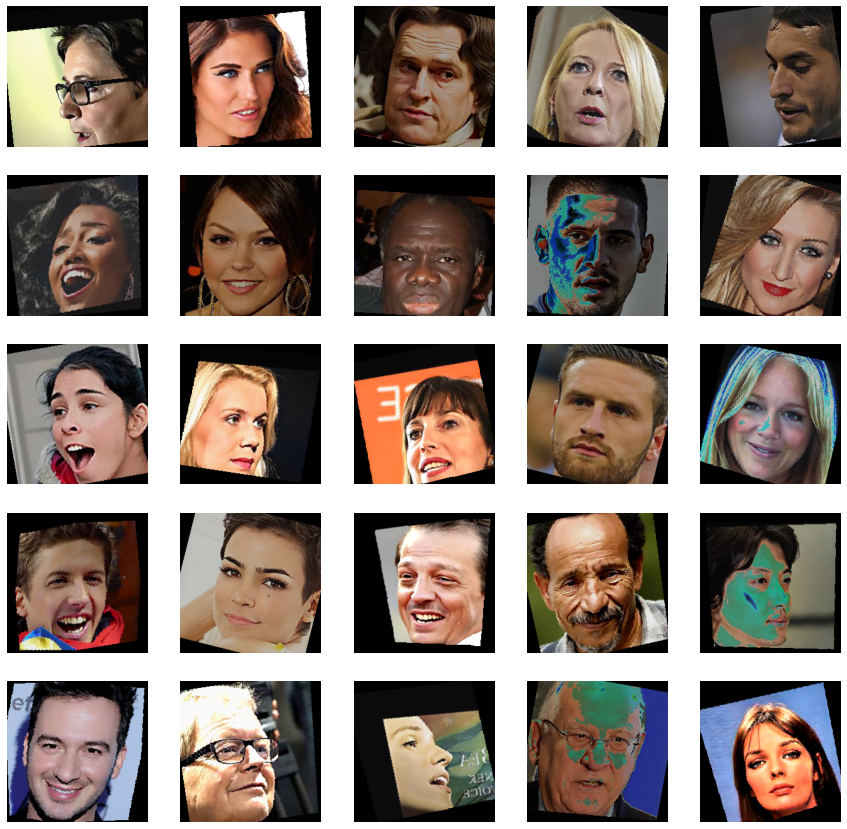

In [ ]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'], 
    shuffle     = True,
)

for data in dtl:
    x, y = data
    
    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Not so Simple ConvNext Network




In [ ]:
#ConvNeXt_Tiny:    depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_prob = 0.1
#ConvNeXt_Small:    depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], drop_prob = 0.4
#ConvNeXt_Base:    depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], drop_prob = 0.5
#ConvNeXt_Large:    depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], drop_prob = 0.5
#ConvNeXt_XLarge:    depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], drop_prob = ?       recommended for 384*384 images


# model = ConvNeXt(in_chans = 3, num_classes = 7000, depths = [3, 3, 9, 3], channels = [96, 192, 384, 768], drop_prob = 0.1).to(DEVICE)
# summary(model, (3, 224, 224))

In [ ]:
from timm.models.layers import trunc_normal_

In [ ]:
def init_weights(model):
    if isinstance(model, (torch.nn.Conv2d, torch.nn.Linear)):
        trunc_normal_(model.weight, std=.02)
        torch.nn.init.constant_(model.bias, 0)

In [ ]:
class Block(torch.nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(dim, dim, kernel_size = 7, stride = 1, padding = 3, groups = dim),
            torch.nn.BatchNorm2d(dim),
            torch.nn.Conv2d(dim, 4 * dim, kernel_size = 1),
            torch.nn.GELU(),
            torch.nn.Conv2d(4 * dim, dim, kernel_size = 1),
        )

        #self.depth = torchvision.ops.StochasticDepth(p = 0.1, mode = "row")

    def forward(self, input):
        output = self.block(input)
        residual_output = input + output


        return residual_output

In [ ]:
class DownsamplingBlock(torch.nn.Module):

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.blockDownsampled = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, kernel_size = 7, stride = 2, padding = 3, groups = in_ch),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.Conv2d(out_ch, 4 * out_ch, kernel_size = 1),
            torch.nn.GELU(),
            torch.nn.Conv2d(4 * out_ch, out_ch, kernel_size = 1),
        )

        self.downBlockResidueal  = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, kernel_size = 1, stride = 2),
            torch.nn.BatchNorm2d(out_ch)
        )

        #self.depth = torchvision.ops.StochasticDepth(p = 0.1, mode = "row")

    def forward(self, input):
        output = self.blockDownsampled(input)
        downsampled_input = self.downBlockResidueal(input)
        residual_output = output + downsampled_input

        return residual_output

In [ ]:
class ConvNext_Orignal(torch.nn.Module):

    def __init__(self, in_channels = 3, num_classes=7000, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]):
        
        super().__init__()

        self.backbone = torch.nn.Sequential(
            # Tranforming the output of 224*224 as 56*56 (Stem Part in paper)
            torch.nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
            torch.nn.BatchNorm2d(dims[0]),

            # Adding Block Layers for Res 2
            *[Block(dim = dims[0]) for i in range(depths[0])],

            # Preparing the input as 28*28 by Downsampling it
            torch.nn.BatchNorm2d(dims[0]),
            torch.nn.Conv2d(dims[0], dims[1], kernel_size=2, stride=2),

            # Adding Block Layers for Res 3
            *[Block(dim = dims[1]) for i in range(depths[1])],

            # Preparing the input as 14*14
            torch.nn.BatchNorm2d(dims[1]),
            torch.nn.Conv2d(dims[1], dims[2], kernel_size=2, stride=2),

            # Adding Block Layers for Res 4
            *[Block(dim = dims[2]) for i in range(depths[2])],

            # Preparing the input as 7*7
            torch.nn.BatchNorm2d(dims[2]),
            torch.nn.Conv2d(dims[2], dims[3], kernel_size=2, stride=2),

            # Adding Block Layers for Res 5
            *[Block(dim = dims[3]) for i in range(depths[3])],

            # Another layer of BatchNorm to normalize the inputs
            torch.nn.BatchNorm2d(dims[3]),

            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten()
        )

        # Flattening my layers
        self.cls_layer = torch.nn.Linear(dims[3], num_classes)

    def forward(self, x, return_feats=False):
        feats = self.backbone(x)
        out = self.cls_layer(feats)

        if return_feats:
            return feats
        else:
            return out


In [ ]:
class ConvNext_Hybrid(torch.nn.Module):

    def __init__(self, in_channels = 3, num_classes=7000, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]):
        
        super().__init__()

        self.backbone = torch.nn.Sequential(
            # Tranforming the output of 224*224 as 56*56 (Stem Part in paper)
            torch.nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
            torch.nn.BatchNorm2d(dims[0]),

            # Adding Block Layers for Res 2 and Downsampling it for Res 3
            *[Block(dim = dims[0]) for i in range(depths[0])],
            DownsamplingBlock(dims[0], dims[1]),

            # Adding Block Layers for Res 3 and Downsampling it for Res 4
            *[Block(dim = dims[1]) for i in range(depths[1]-1)],
            DownsamplingBlock(dims[1], dims[2]),

            # Adding Block Layers for Res 4 and Downsampling it for Res 5
            *[Block(dim = dims[2]) for i in range(depths[2]-1)],
            DownsamplingBlock(dims[2], dims[3]),

            # Adding Block Layers for Res 5
            *[Block(dim = dims[3]) for i in range(depths[3]-1)],

            # Adaptive Average Pooling
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten()
        )

        # Flattening my layers
        self.cls_layer = torch.nn.Linear(dims[3], num_classes)

    def forward(self, x, return_feats=False):
        feats = self.backbone(x)
        out = self.cls_layer(feats)

        if return_feats:
            return feats
        else:
            return out


In [ ]:
# Calling Hybrid ConvNext_Network
model = ConvNext_Hybrid(in_channels = 3, num_classes = 7000, depths = [3, 3, 27, 3], dims = [128, 256, 512, 1024]).to(DEVICE)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           6,272
       BatchNorm2d-2          [-1, 128, 56, 56]             256
            Conv2d-3          [-1, 128, 56, 56]           6,400
       BatchNorm2d-4          [-1, 128, 56, 56]             256
            Conv2d-5          [-1, 512, 56, 56]          66,048
              GELU-6          [-1, 512, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          65,664
             Block-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]           6,400
      BatchNorm2d-10          [-1, 128, 56, 56]             256
           Conv2d-11          [-1, 512, 56, 56]          66,048
             GELU-12          [-1, 512, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          65,664
            Block-14          [-1, 128,

# Setup everything for training

In [ ]:
###############################################
################## Criterion ##################
criterion = torch.nn.CrossEntropyLoss(label_smoothing = config['smoothing'])
################## Criterion ##################
###############################################


###############################################
################## Optimizer ##################
#optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-7, betas=(0.9, 0.999), weight_decay = config['weight_decay'])
optimizer = torch.optim.SGD(model.parameters(), lr = 5e-4, momentum = 0.9, weight_decay = config['weight_decay'])
################## Optimizer ##################
###############################################


###############################################
################## Scheduler ##################
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = config['epochs'], eta_min = 1e-5, verbose=True)
################## Scheduler ##################
###############################################

scaler = torch.cuda.amp.GradScaler()

Adjusting learning rate of group 0 to 5.0000e-04.


In [ ]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [ ]:
print(scheduler)
print(scheduler.T_max)
print(scheduler.eta_min)

30
1e-05


In [ ]:
print(criterion)
print(criterion.label_smoothing)

CrossEntropyLoss()
0.2


# Let's train!

In [ ]:
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        scaler.update()
        batch_bar.update() # Update tqdm bar 

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="2a3537b39181a31bafb5eabede64d932c94e54e8") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Currently logged in as: lsethi (verydeeplearning). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "ConvNext_base_v2_Finetuning_v3", ## Wandb creates random run names if you skip this field
    #reinit = True, ### Allows reinitalizing runs when you re-run this cell
    id = "7wy1x5h7", #Insert specific run id here if you want to resume a previous run
    resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "Lakshay-hw2p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

# Experiments

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [ ]:
checkpoints = torch.load('/content/Checkpoints_Fine/ConvNext_Base_Finetuned_v6.pth')
model.load_state_dict(checkpoints['model_state_dict'])

<All keys matched successfully>

In [ ]:
val_acc, val_loss = validate(model, valid_loader, criterion)

In [ ]:
val_acc

90.53644881170018

In [ ]:
best_valacc = val_acc

In [ ]:
#best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])
    print('Current Learning rate: ', curr_lr)

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    scheduler.step()

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
              'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving the model at epoch: " + str(epoch))
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'train_loss': train_loss,
                  'train_acc': train_acc,
                  'val_loss': val_loss,
                  'val_acc': val_acc, 
                  'epoch': epoch}, ('/content/Checkpoints_Fine/ConvNext_Base_Finetuned_v8.pth'))
      best_valacc = val_acc
      wandb.save('/content/Checkpoints_Fine/ConvNext_Base_Finetuned_v8.pth')

    print('\n\n')

Current Learning rate:  0.0005



Epoch 1/20: 
Train Acc 99.9086%	 Train Loss 2.4457	 Learning Rate 0.0005


Val Acc 90.6221%	 Val Loss 3.1830
Adjusting learning rate of group 0 to 4.9698e-04.



Current Learning rate:  0.0004969836434458088



Epoch 2/20: 
Train Acc 99.8993%	 Train Loss 2.4469	 Learning Rate 0.0005


Val Acc 90.6650%	 Val Loss 3.1691
Adjusting learning rate of group 0 to 4.8801e-04.



Current Learning rate:  0.00048800884649231267



Epoch 3/20: 
Train Acc 99.9079%	 Train Loss 2.4456	 Learning Rate 0.0005


Val Acc 90.5679%	 Val Loss 3.1788
Adjusting learning rate of group 0 to 4.7330e-04.



Current Learning rate:  0.00047329659842615016



Epoch 4/20: 
Train Acc 99.8957%	 Train Loss 2.4459	 Learning Rate 0.0005


Val Acc 90.6050%	 Val Loss 3.1729
Adjusting learning rate of group 0 to 4.5321e-04.



Current Learning rate:  0.0004532091636218622



Epoch 5/20: 
Train Acc 99.9214%	 Train Loss 2.4441	 Learning Rate 0.0005


Val Acc 90.6021%	 Val Loss 3.1739
Adjusting learning rate of group 0 to 4.2824e-04.



Current Learning rate:  0.0004282411613907042



Epoch 6/20: 
Train Acc 99.9172%	 Train Loss 2.4440	 Learning Rate 0.0004


Val Acc 90.6650%	 Val Loss 3.1736
Adjusting learning rate of group 0 to 3.9901e-04.



Current Learning rate:  0.000399007386811656



Epoch 7/20: 
Train Acc 99.9072%	 Train Loss 2.4440	 Learning Rate 0.0004


Val Acc 90.5850%	 Val Loss 3.1582
Adjusting learning rate of group 0 to 3.6623e-04.



Current Learning rate:  0.00036622767243618904


Train:  47%|████▋     | 1027/2188 [05:30<06:12,  3.12it/s, acc=99.9316%, loss=2.4430, lr=0.0004, num_correct=65747]

KeyboardInterrupt: ignored

# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

## Generate csv to submit to Kaggle

In [ ]:
with open("classification_submission_v2.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(5) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-classification-slackkaggle -f classification_submission_v2.csv -m "classification submission_v2"

100% 507k/507k [00:01<00:00, 301kB/s]
Successfully submitted to Face Classification (Slack)

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites 
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities. 

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Using only transforms here and no augmentations since we have image embeddings
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 


100%|██████████| 360/360 [00:00<00:00, 7987.33it/s]

100%|██████████| 720/720 [00:00<00:00, 9158.17it/s]

100%|██████████| 960/960 [00:00<00:00, 10110.51it/s]


# ArcFace Code



In [ ]:
class ArcFaceModel(torch.nn.Module):
    '''
    To train in a standard training loop make sure to modify the train function so you pass in the inputs and the labels
    i.e. output = model(images, labels)
    '''
    def __init__(self, model, margin=0.05, scaler=64, embedding_size=1024, num_classes=7000):
        super(ArcFaceModel, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes

        # small number to avoid invalid arcCos values
        self.eps = 1e-7
        
        # hyperparameters 
        self.margin = margin
        self.scaler = scaler

        # load classification model
        self.model = model

        # Initializing the arcface linear layer with the weights of the classifier from the trained CNN
        self.AFL_linear = torch.nn.Linear(embedding_size, num_classes, bias=False) # Why set bias=False? Check out the paper.
        with torch.no_grad():
          self.AFL_linear.weight.copy_(self.model.cls_layer.weight)

        # Initializing utility functions for normalization, arcCos, cos and onehot encoding
        self.normalizer = torch.nn.functional.normalize
        self.arcCos = torch.acos
        self.cos = torch.cos
        self.one_hot = torch.nn.functional.one_hot

      
    def forward(self, x, labels):
        # Get face embedding
        embedding = self.model(x, return_feats=True)

        # TODO: normalize face embedding
        embedding = self.normalizer(embedding, dim=1)

        # TODO: normalize linear layer weights
        with torch.no_grad():
          self.AFL_linear.weight = torch.nn.Parameter(self.normalizer(self.AFL_linear.weight, dim=1))
        
        # TODO: take dot product to get cos theta, remember that Wx = ||W||||x||cos(\theta) and ||W|| = 1, ||x|| = 1
        cosine = self.AFL_linear(embedding)
        
        # We clamp the values to be a little higher than -1 and a little lower than one so we don't get nan values when we call arccos
        cosine = torch.clamp(cosine, min=-1.0+self.eps, max=1.0-self.eps)
   
        # TODO: get theta by performing arccos(cos(theta))
        theta = self.arcCos(cosine)

        # TODO: convert labels to one-hot
        one_hot_labels = self.one_hot(labels, self.num_classes)
        # TODO: create a mask with m at positions with label 1 and 0 at positions with label 0
        margin_mask = one_hot_labels * self.margin
        # TODO: add margin m to theta
        theta_m = theta + margin_mask

        # calculate the cosine value for theta with margin added and scale with self.scaler
        logits = self.cos(theta_m)*self.scaler # this value is then passed to crossEntropyLoss in train loop to calculate arcface loss

        return logits

# Training Function for Verification

In [ ]:
def trainVerification(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images, labels)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        scaler.update()
        batch_bar.update() # Update tqdm bar 

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validateVerification(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            outputs = model.model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

# Setting up for Verificationtraining

In [ ]:
###############################################
################## Criterion ##################
criterion_ver = torch.nn.CrossEntropyLoss(label_smoothing = config['smoothing'])
################## Criterion ##################
###############################################


###############################################
################## Optimizer ##################
#optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-7, betas=(0.9, 0.999), weight_decay = config['weight_decay'])
optimizer_ver = torch.optim.SGD(model.parameters(), lr = config['lr']/10, momentum = 0.9, weight_decay = config['weight_decay'])
################## Optimizer ##################
###############################################


###############################################
################## Scheduler ##################
scheduler_ver = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ver, T_max = 30, eta_min = config['min_lr'], verbose=True)
################## Scheduler ##################
###############################################

scaler = torch.cuda.amp.GradScaler()

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
optimizer_ver

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [ ]:
print(scheduler_ver)
print(scheduler_ver.T_max)
print(scheduler_ver.eta_min)

30
0.0001


In [ ]:
print(criterion_ver)
print(criterion_ver.label_smoothing)

CrossEntropyLoss()
0.2


In [ ]:
checkpoints = torch.load('/content/Checkpoints_Ver/ConvNext_Base_Verification_epoch_44.pth')
model.load_state_dict(checkpoints['model_state_dict'])

<All keys matched successfully>

In [ ]:
arcFacemodel = ArcFaceModel(model).to(DEVICE)

# New WanDB for cerification

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "ConvNext_base_v2_Verification", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "Lakshay-hw2p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

# Experiment

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [ ]:
best_veracc = 0.0

for epoch in range(30):

    curr_lr = float(optimizer_ver.param_groups[0]['lr'])
    print('Current Learning rate: ', curr_lr)

    train_acc, train_loss = trainVerification(arcFacemodel, train_loader, optimizer_ver, criterion_ver)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        30,
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validateVerification(arcFacemodel, valid_loader, criterion_ver)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    scheduler_ver.step()

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
              'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_veracc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving the model at epoch: " + str(epoch))
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer_ver.state_dict(),
                  'scheduler_state_dict':scheduler_ver.state_dict(),
                  'train_loss': train_loss,
                  'train_acc': train_acc,
                  'val_loss': val_loss,
                  'val_acc': val_acc, 
                  'epoch': epoch}, ('/content/Checkpoints_Ver/ConvNext_Base_Verification_epoch_' + str(epoch+16) +'.pth'))
      best_valacc = val_acc
      wandb.save('/content/Checkpoints_Ver/ConvNext_Base_Verification_epoch_' + str(epoch+16) +'.pth')

    print('\n\n')

Current Learning rate:  0.01



Epoch 1/30: 
Train Acc 41.7464%	 Train Loss 7.7204	 Learning Rate 0.0100


Val Acc 89.9709%	 Val Loss 4.1652
Adjusting learning rate of group 0 to 9.9729e-03.
Saving the model at epoch: 0


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.009972883382072953



Epoch 2/30: 
Train Acc 44.4571%	 Train Loss 7.2081	 Learning Rate 0.0100


Val Acc 89.9337%	 Val Loss 4.3538
Adjusting learning rate of group 0 to 9.8918e-03.
Saving the model at epoch: 1


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.009891830623632338



Epoch 3/30: 
Train Acc 46.1736%	 Train Loss 6.8958	 Learning Rate 0.0099


Val Acc 90.0223%	 Val Loss 4.6185
Adjusting learning rate of group 0 to 9.7577e-03.
Saving the model at epoch: 2


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.009757729755661011



Epoch 4/30: 
Train Acc 47.6664%	 Train Loss 6.6450	 Learning Rate 0.0098


Val Acc 89.9109%	 Val Loss 4.8718
Adjusting learning rate of group 0 to 9.5721e-03.
Saving the model at epoch: 3


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.009572050015330874



Epoch 5/30: 
Train Acc 49.3757%	 Train Loss 6.4087	 Learning Rate 0.0096


Val Acc 90.0051%	 Val Loss 4.7388
Adjusting learning rate of group 0 to 9.3368e-03.
Saving the model at epoch: 4


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.009336825748732973



Epoch 6/30: 
Train Acc 50.9471%	 Train Loss 6.1989	 Learning Rate 0.0093


Val Acc 89.8995%	 Val Loss 5.0519
Adjusting learning rate of group 0 to 9.0546e-03.
Saving the model at epoch: 5


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.00905463412215599



Epoch 7/30: 
Train Acc 53.4557%	 Train Loss 5.9688	 Learning Rate 0.0091


Val Acc 90.0166%	 Val Loss 5.1826
Adjusting learning rate of group 0 to 8.7286e-03.
Saving the model at epoch: 6


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.008728566886113101



Epoch 8/30: 
Train Acc 55.4343%	 Train Loss 5.7657	 Learning Rate 0.0087


Val Acc 89.8680%	 Val Loss 5.2732
Adjusting learning rate of group 0 to 8.3622e-03.
Saving the model at epoch: 7


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.008362196501476349



Epoch 9/30: 
Train Acc 58.3743%	 Train Loss 5.5372	 Learning Rate 0.0084


Val Acc 89.6395%	 Val Loss 5.4138
Adjusting learning rate of group 0 to 7.9595e-03.
Saving the model at epoch: 8


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.007959536998847742



Epoch 10/30: 
Train Acc 61.1057%	 Train Loss 5.3084	 Learning Rate 0.0080


Val Acc 89.8195%	 Val Loss 5.4379
Adjusting learning rate of group 0 to 7.5250e-03.
Saving the model at epoch: 9


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.007525000000000001



Epoch 11/30: 
Train Acc 64.4043%	 Train Loss 5.0857	 Learning Rate 0.0075


Val Acc 89.8480%	 Val Loss 5.5896
Adjusting learning rate of group 0 to 7.0633e-03.
Saving the model at epoch: 10


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.007063346383225214



Epoch 12/30: 
Train Acc 67.4486%	 Train Loss 4.8773	 Learning Rate 0.0071


Val Acc 89.8509%	 Val Loss 5.7546
Adjusting learning rate of group 0 to 6.5796e-03.
Saving the model at epoch: 11


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.006579634122155992



Epoch 13/30: 
Train Acc 70.6671%	 Train Loss 4.6810	 Learning Rate 0.0066


Val Acc 89.9566%	 Val Loss 5.8535
Adjusting learning rate of group 0 to 6.0792e-03.
Saving the model at epoch: 12


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.00607916286954791



Epoch 14/30: 
Train Acc 74.4064%	 Train Loss 4.4801	 Learning Rate 0.0061


Val Acc 89.9623%	 Val Loss 6.1196
Adjusting learning rate of group 0 to 5.5674e-03.
Saving the model at epoch: 13


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.005567415893174887



Epoch 15/30: 
Train Acc 77.8693%	 Train Loss 4.3129	 Learning Rate 0.0056


Val Acc 89.9737%	 Val Loss 6.1708
Adjusting learning rate of group 0 to 5.0500e-03.
Saving the model at epoch: 14


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.005050000000000003



Epoch 16/30: 
Train Acc 81.2679%	 Train Loss 4.1634	 Learning Rate 0.0051


Val Acc 89.9766%	 Val Loss 6.2977
Adjusting learning rate of group 0 to 4.5326e-03.
Saving the model at epoch: 15


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.004532584106825118



Epoch 17/30: 
Train Acc 84.5043%	 Train Loss 4.0405	 Learning Rate 0.0045


Val Acc 90.0080%	 Val Loss 6.4770
Adjusting learning rate of group 0 to 4.0208e-03.
Saving the model at epoch: 16


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.004020837130452093



Epoch 18/30: 
Train Acc 87.0914%	 Train Loss 3.9415	 Learning Rate 0.0040


Val Acc 89.9594%	 Val Loss 6.5768
Adjusting learning rate of group 0 to 3.5204e-03.
Saving the model at epoch: 17


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.003520365877844012



Epoch 19/30: 
Train Acc 89.4843%	 Train Loss 3.8528	 Learning Rate 0.0035


Val Acc 89.8623%	 Val Loss 6.6835
Adjusting learning rate of group 0 to 3.0367e-03.
Saving the model at epoch: 18


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.003036653616774791



Epoch 20/30: 
Train Acc 91.2707%	 Train Loss 3.7832	 Learning Rate 0.0030


Val Acc 89.9537%	 Val Loss 6.7911
Adjusting learning rate of group 0 to 2.5750e-03.
Saving the model at epoch: 19


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0025750000000000018



Epoch 21/30: 
Train Acc 92.7529%	 Train Loss 3.7234	 Learning Rate 0.0026


Val Acc 89.9966%	 Val Loss 6.8724
Adjusting learning rate of group 0 to 2.1405e-03.
Saving the model at epoch: 20


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0021404630011522593



Epoch 22/30: 
Train Acc 94.0000%	 Train Loss 3.6667	 Learning Rate 0.0021


Val Acc 90.0594%	 Val Loss 6.9286
Adjusting learning rate of group 0 to 1.7378e-03.
Saving the model at epoch: 21


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0017378034985236542



Epoch 23/30: 
Train Acc 94.9443%	 Train Loss 3.6194	 Learning Rate 0.0017


Val Acc 89.9223%	 Val Loss 6.9992
Adjusting learning rate of group 0 to 1.3714e-03.
Saving the model at epoch: 22


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0013714331138869004



Epoch 24/30: 
Train Acc 95.5686%	 Train Loss 3.5804	 Learning Rate 0.0014


Val Acc 90.0623%	 Val Loss 7.0224
Adjusting learning rate of group 0 to 1.0454e-03.
Saving the model at epoch: 23


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0010453658778440112



Epoch 25/30: 
Train Acc 96.2357%	 Train Loss 3.5463	 Learning Rate 0.0010


Val Acc 90.0994%	 Val Loss 7.0305
Adjusting learning rate of group 0 to 7.6317e-04.
Saving the model at epoch: 24


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0007631742512670288



Epoch 26/30: 
Train Acc 96.5400%	 Train Loss 3.5211	 Learning Rate 0.0008


Val Acc 90.1651%	 Val Loss 7.0777
Adjusting learning rate of group 0 to 5.2795e-04.
Saving the model at epoch: 25


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0005279499846691254



Epoch 27/30: 
Train Acc 96.7743%	 Train Loss 3.5037	 Learning Rate 0.0005


Val Acc 90.0965%	 Val Loss 7.0692
Adjusting learning rate of group 0 to 3.4227e-04.
Saving the model at epoch: 26


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.00034227024433899016



Epoch 28/30: 
Train Acc 96.9850%	 Train Loss 3.4903	 Learning Rate 0.0003


Val Acc 90.1708%	 Val Loss 7.0891
Adjusting learning rate of group 0 to 2.0817e-04.
Saving the model at epoch: 27


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.00020816937636766194



Epoch 29/30: 
Train Acc 97.1314%	 Train Loss 3.4800	 Learning Rate 0.0002


Val Acc 90.1223%	 Val Loss 7.0868
Adjusting learning rate of group 0 to 1.2712e-04.
Saving the model at epoch: 28


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")





Current Learning rate:  0.0001271166179270467



Epoch 30/30: 
Train Acc 97.1643%	 Train Loss 3.4735	 Learning Rate 0.0001


Val Acc 90.1708%	 Val Loss 7.0951
Adjusting learning rate of group 0 to 1.0000e-04.
Saving the model at epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


# Testing

In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, threshold, batch_size= 32, mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model         
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain 
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    # pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings
    
    # After early submission, remove the previous line and uncomment the following code 

    # threshold = # Choose a proper threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return pred_id_strings

In [ ]:
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, 0.35, 64, mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, 0.35, 64, mode='test')

Verification Accuracy = 0.6333333333333333


In [ ]:
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, 64, mode='val')

Threshold:  0.01
Verification Accuracy = 0.6138888888888889
Threshold:  0.02
Verification Accuracy = 0.6138888888888889
Threshold:  0.03
Verification Accuracy = 0.6138888888888889
Threshold:  0.04
Verification Accuracy = 0.6138888888888889
Threshold:  0.05
Verification Accuracy = 0.6138888888888889
Threshold:  0.06
Verification Accuracy = 0.6138888888888889
Threshold:  0.07
Verification Accuracy = 0.6138888888888889
Threshold:  0.08
Verification Accuracy = 0.6138888888888889
Threshold:  0.09
Verification Accuracy = 0.6138888888888889
Threshold:  0.1
Verification Accuracy = 0.6138888888888889
Threshold:  0.11
Verification Accuracy = 0.6138888888888889
Threshold:  0.12
Verification Accuracy = 0.6138888888888889
Threshold:  0.13
Verification Accuracy = 0.6138888888888889
Threshold:  0.14
Verification Accuracy = 0.6138888888888889
Threshold:  0.15
Verification Accuracy = 0.6138888888888889
Threshold:  0.16
Verification Accuracy = 0.6138888888888889
Threshold:  0.17
Verification Accuracy = 

In [ ]:
# add your finetune/retrain code here

## Generate csv to submit to Kaggle

In [ ]:
with open("verification_submission_base_New_v3_0.35.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-verification-slack -f verification_submission_base_New_v3_0.35.csv -m "ver submission new_v3_0.35"

100% 8.34k/8.34k [00:01<00:00, 5.29kB/s]
Successfully submitted to Face Verification (Slack)